In [1]:
# importing neccessary Packages
import pickle
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from time import gmtime, strftime
import matplotlib.pyplot as plt

import os, sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (12, 7)
pd.set_option('display.max_columns', None)

sns.set_style("darkgrid")
%matplotlib inline

In [4]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from file_handler import FileHandler
from log import get_logger

file_handler = FileHandler() 
my_logger = get_logger("Prediction")

import warnings
warnings.filterwarnings('ignore')

In [5]:
train_data = pd.read_csv("../data/cleaned_train.csv")
test_data = pd.read_csv("../data/cleaned_test.csv")
tain_store_data = pd.read_csv("../data/clean_train_store.csv")

#### Preprocessing 

In [6]:
try:
    # Train with only by the opened stores and Sales greater than zero.
    
    train_data = train_data[train_data['Open'] == 1]
    train_data = train_data[train_data['Sales'] > 0.0]

    # Label encode Date in both training and testing datasets
    for dataset in (train_data, test_data):
        encoder = preprocessing.LabelEncoder()
        dataset['Date'] = encoder.fit_transform(dataset['Date'])

    my_logger.debug("Date is encoded successfully.")
            
except Exception as e:
    my_logger.exception(f'Exception occured in Date encoding!, {e}')

2022-09-09 13:46:07,155 — Prediction — DEBUG — Date is encoded successfully.


##### Handling categorical Values 

In [6]:
### Label encoding
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
train_x['StoreType'] = lb.fit_transform(train_x['StoreType'])
train_x['Assortment'] = lb.fit_transform(train_x['Assortment'])

train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 32054 to 67589
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                1000 non-null   int64  
 1   DayOfWeek            1000 non-null   int64  
 2   Open                 1000 non-null   int64  
 3   Promo                1000 non-null   int64  
 4   SchoolHoliday        1000 non-null   int64  
 5   Day                  1000 non-null   int64  
 6   WeekOfYear           1000 non-null   int64  
 7   Month                1000 non-null   int64  
 8   Year                 1000 non-null   int64  
 9   StoreType            1000 non-null   int32  
 10  Assortment           1000 non-null   int32  
 11  CompetitionDistance  1000 non-null   float64
 12  Promo2               1000 non-null   int64  
dtypes: float64(1), int32(2), int64(10)
memory usage: 101.6 KB


In [7]:
train_x.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,Day,WeekOfYear,Month,Year,StoreType,Assortment,CompetitionDistance,Promo2
32054,35,6,1,0,0,29,26,6,2013,3,1,7660.000,1
33783,37,5,1,1,0,31,22,5,2013,2,0,4230.000,0
18228,20,7,0,0,0,1,35,9,2013,3,0,2340.000,1
36624,40,4,1,1,0,16,20,5,2013,0,0,180.000,1
41090,45,1,1,1,1,15,29,7,2013,3,0,9710.000,0


In [8]:
try:
    # Train with only by the opened stores and Sales greater than zero.
    
    train_data = train_data[train_data['Open'] == 1]
    train_data = train_data[train_data['Sales'] > 0.0]

    # Label encode Date in both training and testing datasets
    for dataset in (train_data, test_data):
        encoder = preprocessing.LabelEncoder()
        dataset['Date'] = encoder.fit_transform(dataset['Date'])

    my_logger.debug("Date is encoded successfully.")
            
except Exception as e:
    my_logger.exception(f'Exception occured in Date encoding!, {e}')

2022-09-09 12:14:38,217 — Forcasting — DEBUG — Date is encoded successfully.


In [7]:
scaler = MinMaxScaler()

trainining_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',\
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',\
                    'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear']

testing_columns = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday','SchoolHoliday', 'StoreType', 'Assortment',\
                  'CompetitionDistance','CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', \
                  'Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year', 'DayOfYear', 'WeekOfYear']

temp_train_data = train_data.copy()
temp_test_data = test_data.copy()   

try:
    for i in trainining_columns:
    
        # fit on training data column
        scale = scaler.fit(temp_train_data[[i]])
        
        # transform the training data column
        temp_train_data[i] = scale.transform(temp_train_data[[i]])
    
    for i in testing_columns:
    
        # fit on training data column
        scale = scaler.fit(temp_test_data[[i]])
        
        # transform the training data column
        temp_test_data[i] = scale.transform(temp_test_data[[i]]) 
    
    my_logger.debug("Data is Normalized successfully.")
    
except Exception as e:
    my_logger.debug(f"Exception occured while Normalizing the dataset, {e}")

2022-09-09 13:47:03,234 — Prediction — DEBUG — Exception occured while Normalizing the dataset, "None of [Index(['StoreType'], dtype='object')] are in the [columns]"


In [10]:
temp_train_data.describe()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,SalePerCustomer,DayOfYear
count,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000,844338.000
mean,0.500,0.420,0.494,0.486,0.493,0.000,0.446,0.000,0.194,0.402,0.468,0.288,0.386,0.893,0.499,0.232,0.893,0.269,0.416,0.441,0.495,0.444,9.539,0.443
std,0.289,0.287,0.292,0.197,0.203,0.000,0.497,0.016,0.395,0.454,0.497,0.323,0.357,0.087,0.500,0.306,0.087,0.327,0.389,0.302,0.289,0.282,2.109,0.278
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.752,0.000
25%,0.250,0.167,0.241,0.344,0.346,0.000,0.000,0.000,0.000,0.000,0.000,0.043,0.000,0.783,0.000,0.000,0.783,0.000,0.000,0.182,0.233,0.196,7.990,0.203
50%,0.500,0.333,0.482,0.452,0.452,0.000,0.000,0.000,0.000,0.000,0.000,0.143,0.273,0.922,0.000,0.000,0.922,0.000,0.500,0.455,0.500,0.431,9.357,0.420
75%,0.750,0.667,0.753,0.594,0.599,0.000,1.000,0.000,0.000,1.000,1.000,0.426,0.727,0.965,1.000,0.440,0.965,0.333,0.500,0.636,0.733,0.667,10.871,0.659
max,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,53.828,1.000


<AxesSubplot:xlabel='Date', ylabel='Sales'>

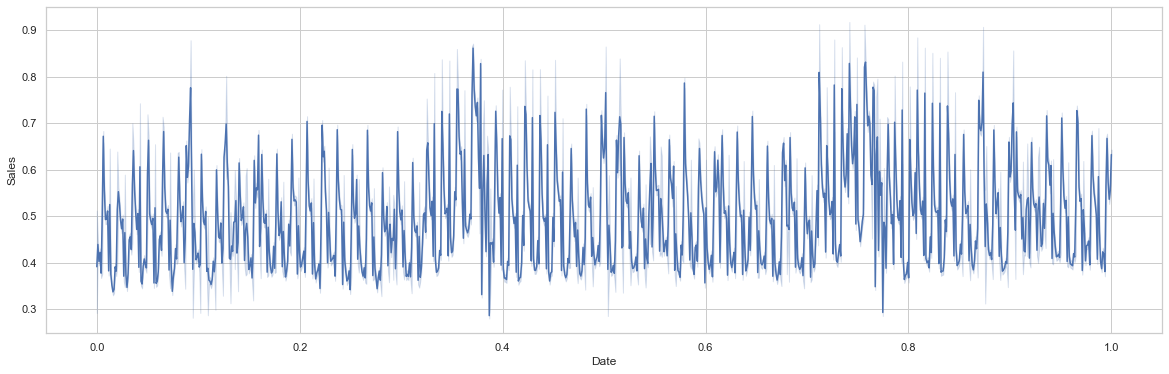

In [11]:
# Using Scaled Units
plt.figure(figsize=(20,6))
sns.set(style="whitegrid")
sns.lineplot(x='Date',y='Sales',data=temp_train_data)

In [12]:
# sample_train = temp_train_data.sample(10000)

y_target = temp_train_data.Sales
x_features =  temp_train_data.drop(columns=['Sales', 'Customers'], axis=1)

In [13]:
# Train-test splitting the dataset

try: 
    x_train, x_train_test, y_train, y_train_test = train_test_split(x_features, y_target, test_size=0.20, random_state=15)
    my_logger.info("Train Test split done successfully.")

except Exception as e:
    print(e)
    my_logger.debug(f"Exception occured in separating dataset into x & y_training dataset, {e}")

2022-09-09 12:38:34,131 — Forcasting — INFO — Train Test split done successfully.


In [14]:
x_train.shape

(675470, 22)

In [18]:
def evaluate_models(model_=None, **kwargs):
    """
    - Evaluate our classifiers
    """
    model_name = model_.__name__
    scores = 0.0
    exp_name = "Modeling with "+ model_name
    mlflow.sklearn.autolog()
    with mlflow.start_run(run_name = exp_name) as run:
        mlflow.set_tag("mlflow.runName", exp_name)
        model = model_(**kwargs)
        model.fit(x_train,y_train)
        mlflow.sklearn.log_model(model,"Regressor Model")
        my_logger.info(f"fitted a {model} model")
        
        # Then predict results from x_train_test data
        predicted_data = model.predict(x_train_test)
        scores = mean_absolute_error(y_train_test, predicted_data)
        my_logger.info("predicting for a group instance")
        mlflow.log_metric("scores",scores)
        
        # serialize the model
        file_handler.save_model(model, model_name)

    return (scores, predicted_data) 

In [19]:
# training using cross validation set
regressor_validation=RandomForestRegressor(n_estimators=128, 
                             criterion='mse', 
                             max_depth=20, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             max_leaf_nodes=None, 
                             min_impurity_decrease=0.0,  
                             bootstrap=True, 
                             oob_score=False,
                             n_jobs=4, 
                             random_state=35, 
                             verbose=0, 
                             warm_start=False)
# try:
#     rf_model_test=regressor_validation.fit(x_train,y_train)

# except Exception as e:
#     my_logger(f"Model fitting failed to complete, {e}")

In [22]:
try:
    RF_prediction = evaluate_models(model_=RandomForestRegressor, n_estimators=10)

except Exception as e:
    my_logger(f"Model fitting failed to complete, {e}")

2022-09-09 13:09:28,165 — Forcasting — INFO — fitted a RandomForestRegressor(n_estimators=10) model
2022-09-09 13:09:32,832 — Forcasting — INFO — predicting for a group instance
2022-09-09 13:09:32,839 — FileHandler — ERROR — save failed
Traceback (most recent call last):
  File "C:\Users\mo\Desktop\10-Academy Project\Pharmaceutical-Sales-Forcasting\scripts\file_handler.py", line 38, in save_model
    with open(f'../models/{file_name}.pkl', 'wb') as my_model:
FileNotFoundError: [Errno 2] No such file or directory: '../models/RandomForestRegressor_model 2022-09-09 10-09-32.pkl'


In [23]:
mae, predictions = RF_prediction
mae

0.035897716971240216

In [24]:
try:
    LGBM_prediction = evaluate_models(model_ = LGBMRegressor, n_estimators = 10)

except Exception as e:
    my_logger(f"Model fitting failed to complete, {e}")

2022-09-09 13:13:14,308 — Forcasting — INFO — fitted a LGBMRegressor(n_estimators=10) model
2022-09-09 13:13:14,480 — Forcasting — INFO — predicting for a group instance
2022-09-09 13:13:14,491 — FileHandler — ERROR — save failed
Traceback (most recent call last):
  File "C:\Users\mo\Desktop\10-Academy Project\Pharmaceutical-Sales-Forcasting\scripts\file_handler.py", line 38, in save_model
    with open(f'../models/{file_name}.pkl', 'wb') as my_model:
FileNotFoundError: [Errno 2] No such file or directory: '../models/LGBMRegressor_model 2022-09-09 10-13-14.pkl'


In [25]:
mae, predictions = LGBM_prediction
mae

0.12573318453633267